In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.externals import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, make_scorer

from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adagrad


Using TensorFlow backend.
D:\Anaconda3\megatest\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\megatest\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\megatest\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\megatest\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Future

In [3]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def train_to_test_split(train_x, train_y):
    sc = MinMaxScaler()
    train_x = sc.fit_transform(train_x)
#     joblib.dump(sc.fit(train_x), scaler_filename) 
    return train_test_split(train_x, train_y, test_size=0.3, random_state=5)


def kfold(clf):
    kf = KFold(len(dt.index), n_folds=10, shuffle=True, random_state=111)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = dt.loc[:,'age':'thal'].values[train_index], dt.loc[:,'age':'thal'].values[test_index]
        y_train, y_test = dt['target'].values[train_index], dt['target'].values[test_index]
        clf.fit(X_train, y_train)
        prediction = clf.predict(X_test)
        accuracy = accuracy_score(y_test, prediction)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

    
def grid_search(clf, parameters, X_train, y_train):
    acc_scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, n_jobs=-1, cv=5)
    grid_obj = grid_obj.fit(X_train, y_train.values.ravel())
    clf = grid_obj.best_estimator_
    return(clf)
    
    
def classifier(clf):
    
    clf_name = clf.__class__.__name__
    parameters = parameter_set(clf_name)
    print(parameters)
    # return predictions from gird search best model
    clf = grid_search(clf, parameters, X_train, y_train)
    
    # fit best model
    clf.fit(X_train, y_train.values.ravel())
    
    predictions = clf.predict(X_test) 
    if clf_name == 'XGBClassifier':
        predictions = [value for value in predictions]
    return(predictions)

def parameter_set(clf_name):
    if clf_name == 'RandomForestClassifier':
        parameters = {'n_estimators': [5, 10, 50, 100, 150, 200], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
#               'max_depth': list(range(2,10)), 
#               'min_samples_split': list(range(2,5)),
#               'min_samples_leaf': list(range(1,5)),
              'verbose': [0]
             }
    if clf_name == 'DecisionTreeClassifier':
        parameters = {
              'max_depth': list(range(2,10)), 
              'min_samples_split': list(range(2,10))
             }
    if clf_name == 'AdaBoostClassifier':
        parameters = {
            "n_estimators" : [5, 10, 50, 100, 150, 200],
            "algorithm" :  ["SAMME", "SAMME.R"],
            'learning_rate':[0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7]
             }
    if clf_name == 'GradientBoostingClassifier':
        parameters = {
            "loss":["deviance"],
            "learning_rate": [0.075, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7],
#             "min_samples_split": list(range(2,5)),
#             "min_samples_leaf": list(range(1,5)),
            "max_depth": [3,5,8],
            "max_features": ["log2","sqrt"],
            "criterion": ["friedman_mse",  "mae"],
            "subsample": [0.5, 0.8, 0.9, 1.0],
            "n_estimators": [5, 10, 50, 100, 150, 200]
             }
    if clf_name == 'XGBClassifier':
        parameters = {
            'learning_rate': np.linspace(0.01, 0.5, 9),
#             'max_depth': list(range(5,10)),
#             'min_child_weight': list(range(3,10)),
            'gamma': np.linspace(0, 0.5, 11),
#             'subsample': [0.8, 0.9],
#             'colsample_bytree': [0.3, 0.4, 0.5 , 0.7, 0.8, 0.9],
            'objective': ['binary:logistic']
        }
    return(parameters)

In [4]:
dt = pd.read_csv("../input/heart.csv")
X_train, X_test, y_train, y_test = train_to_test_split(dt[dt.columns[0:13]] ,dt[['target']])

FileNotFoundError: [Errno 2] File b'../input/heart.csv' does not exist: b'../input/heart.csv'

In [4]:
model = Sequential()
model.add(Dense(units=512, activation='relu', input_dim=np.shape(X_train)[1]))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3, noise_shape=None, seed=None))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3, noise_shape=None, seed=None))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3, noise_shape=None, seed=None))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3, noise_shape=None, seed=None))
model.add(Dense(units=1, activation='sigmoid'))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               7168      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
__________

In [6]:
opt = optimizers.SGD()
model.compile(loss="binary_crossentropy", optimizer=opt, metrics = ["accuracy"])

In [7]:
result = model.fit(X_train, y_train ,epochs=100, batch_size=16, validation_split=0.1, shuffle=True)

Train on 190 samples, validate on 22 samples
Epoch 1/100
190/190 [==============================] - 1s 4ms/step - loss: 0.6925 - acc: 0.5105 - val_loss: 0.6915 - val_acc: 0.5455
Epoch 2/100
190/190 [==============================] - 0s 268us/step - loss: 0.6954 - acc: 0.4789 - val_loss: 0.6904 - val_acc: 0.7273
Epoch 3/100
190/190 [==============================] - 0s 246us/step - loss: 0.6953 - acc: 0.4842 - val_loss: 0.6887 - val_acc: 0.6818
Epoch 4/100
190/190 [==============================] - 0s 242us/step - loss: 0.6920 - acc: 0.6000 - val_loss: 0.6879 - val_acc: 0.6364
Epoch 5/100
190/190 [==============================] - 0s 241us/step - loss: 0.6927 - acc: 0.5737 - val_loss: 0.6871 - val_acc: 0.6364
Epoch 6/100
190/190 [==============================] - 0s 251us/step - loss: 0.6938 - acc: 0.5316 - val_loss: 0.6864 - val_acc: 0.6364
Epoch 7/100
190/190 [==============================] - 0s 247us/step - loss: 0.6910 - acc: 0.5632 - val_loss: 0.6854 - val_acc: 0.6364
Epoch 8/100


In [8]:
MLP_acc = accuracy_score(y_test, model.predict_classes(X_test))
MLP_loss = log_loss(y_test, model.predict_classes(X_test))
print(MLP_acc)
print(MLP_loss)

0.8901098901098901
3.7954962938615107


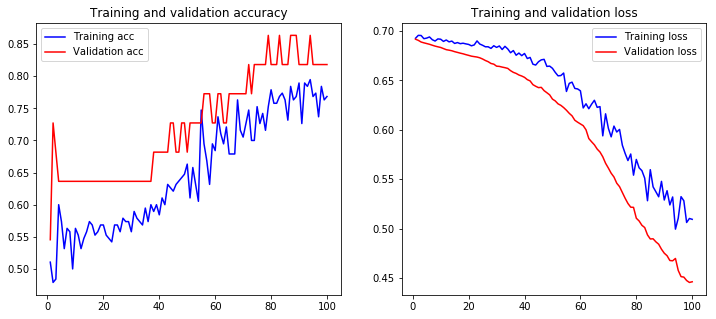

In [9]:
plot_history(result)

In [10]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    xgb.XGBClassifier()
]

In [11]:
# Logging for Visual Comparison# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy"]
log = pd.DataFrame([['MLP', MLP_acc*100]],columns=log_cols)

for clf in classifiers:
    
    name = clf.__class__.__name__
    clf.fit(X_train, y_train.values.ravel())
    print("="*30)
    print(name)
    
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.2%}".format(acc))
    
    log_entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

DecisionTreeClassifier
Accuracy: 81.32%
RandomForestClassifier
Accuracy: 83.52%
AdaBoostClassifier
Accuracy: 84.62%
GradientBoostingClassifier
Accuracy: 84.62%
XGBClassifier
Accuracy: 86.81%


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [12]:
# Grid Search
for clf in classifiers:
    name = clf.__class__.__name__ + 'Grid'
    print("="*30)
    print(name)
    train_predictions = classifier(clf)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.2%}".format(acc))
    log_entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    log = log.append(log_entry)
print("="*30)


DecisionTreeClassifierGrid
{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]}
Accuracy: 86.81%
RandomForestClassifierGrid
{'n_estimators': [5, 10, 50, 100, 150, 200], 'max_features': ['log2', 'sqrt', 'auto'], 'criterion': ['entropy', 'gini'], 'verbose': [0]}
Accuracy: 90.11%
AdaBoostClassifierGrid
{'n_estimators': [5, 10, 50, 100, 150, 200], 'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7]}
Accuracy: 91.21%
GradientBoostingClassifierGrid
{'loss': ['deviance'], 'learning_rate': [0.075, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7], 'max_depth': [3, 5, 8], 'max_features': ['log2', 'sqrt'], 'criterion': ['friedman_mse', 'mae'], 'subsample': [0.5, 0.8, 0.9, 1.0], 'n_estimators': [5, 10, 50, 100, 150, 200]}
Accuracy: 91.21%
XGBClassifierGrid
{'learning_rate': array([0.01   , 0.07125, 0.1325 , 0.19375, 0.255  , 0.31625, 0.3775 ,
       0.43875, 0.5    ]), 'gamma': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 

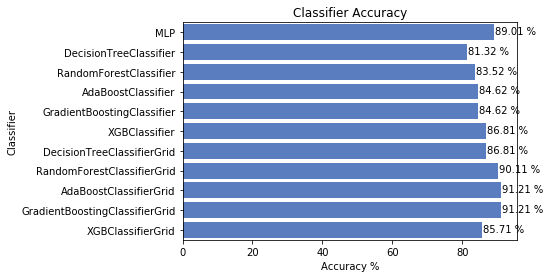

In [13]:
sns.set_color_codes("muted")
g=sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')  

for p in g.patches:
    x = p.get_x() + p.get_width() +.3
    y = p.get_y() + p.get_height()/2 + .1
    g.annotate("%.2f %%" % (p.get_width()), (x, y))

plt.show()



In [14]:
clf = classifiers[1] 
clf.fit(X_train, y_train.values.ravel())
# model_name = '../model/'+clf.__class__.__name__+'_00001.pkl'
# joblib.dump(clf, model_name) 


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
print('Loading ' + clf.__class__.__name__)
# clf = joblib.load(model_name) 
# scaler = joblib.load(scaler_filename) 

input_dt = [37,1,3,130,250,1,0,187,0,2.3,0,0,1]
input_dt = np.array(input_dt).reshape(1, -1)
# input_dt = scaler.transform(input_dt)
train_predictions = clf.predict(input_dt)


print('Result is: ' + str(float(train_predictions)))

Loading RandomForestClassifier
Result is: 1.0


# 2019/06/11 Note
- SGD is better then adam in some seed.

# 2019/07/10 Note
- Cross Validation With Parameter Tuning Using Grid Search.
- Calculate the accuracy score of MLP using test dataset.